# descrição

inspirado em 

+ [QuickDraw Baseline LSTM Reading and Submission | Kaggle](https://www.kaggle.com/kmader/quickdraw-baseline-lstm-reading-and-submission)
+ [Time-series data analysis using LSTM (Tutorial) | Kaggle](https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial/notebook)
+ [PyTorch LSTM: The Definitive Guide | cnvrg.io](https://cnvrg.io/pytorch-lstm/)
+ [Implementation Differences in LSTM Layers: TensorFlow vs PyTorch | by Madhushan Buwaneswaran | Towards Data Science](https://towardsdatascience.com/implementation-differences-in-lstm-layers-tensorflow-vs-pytorch-77a31d742f74)
+ [PyTorch Lightning, LSTM, Timeseries, Clean code | Kaggle](https://www.kaggle.com/tartakovsky/pytorch-lightning-lstm-timeseries-clean-code)
+ [PyTorch Lightning 1.0: From 0–600k | by PyTorch Lightning team | PyTorch | Medium](https://medium.com/pytorch/pytorch-lightning-1-0-from-0-600k-80fc65e2fab0)
+ [Use PyTorch Lightning With Weights and Biases | Kaggle](https://www.kaggle.com/ayuraj/use-pytorch-lightning-with-weights-and-biases)

dados em

+ [Household Electric Power Consumption | Kaggle](https://www.kaggle.com/uciml/electric-power-consumption-data-set)

# libs

In [1]:
import sys

import numpy  as np
import pandas as pd
import gc
import pprint
import hashlib

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn           as sns

from IPython.display import display

In [2]:
df = pd.read_csv("~/Documents/data/household-power-consumption/household_power_consumption.txt",
                 sep=";", 
                 parse_dates={'dt':['Date', 'Time']},
                 infer_datetime_format=True,
                 low_memory=True,
                 na_values=['nan', '?']
                ).set_index("dt")

In [3]:
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


# tratamento

## missing

In [4]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [5]:
for c in df.columns:
    df[c] = df[c].fillna(df[c].mean())

In [6]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

# visualizacao

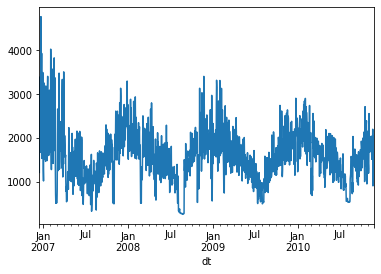

In [7]:
df['Global_active_power'].resample("D").sum().plot();

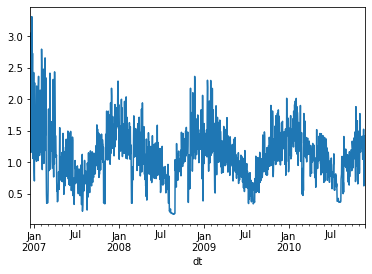

In [8]:
df['Global_active_power'].resample("D").mean().plot();

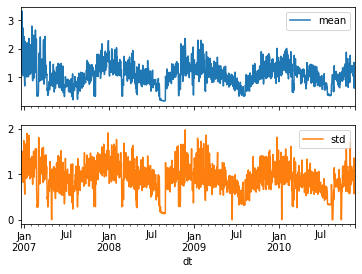

In [9]:
rs = df['Global_active_power'].resample("D").agg(['mean', 'std']);
rs.plot(subplots = True);

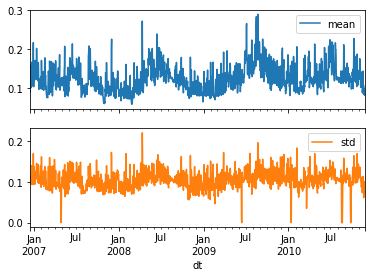

In [10]:
rs = df['Global_reactive_power'].resample("D").agg(['mean', 'std']);
rs.plot(subplots = True);

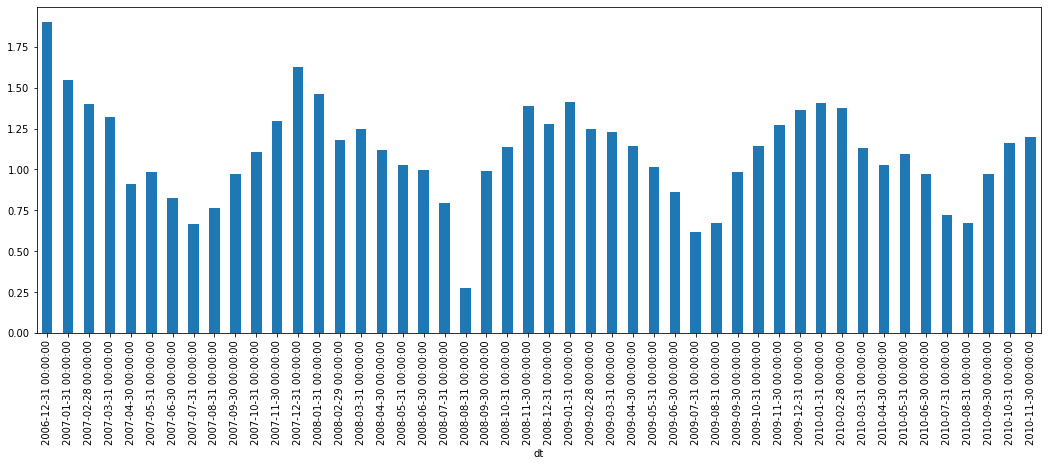

In [11]:
df['Global_active_power'].resample("M").mean().plot(kind="bar", figsize=(18,6));

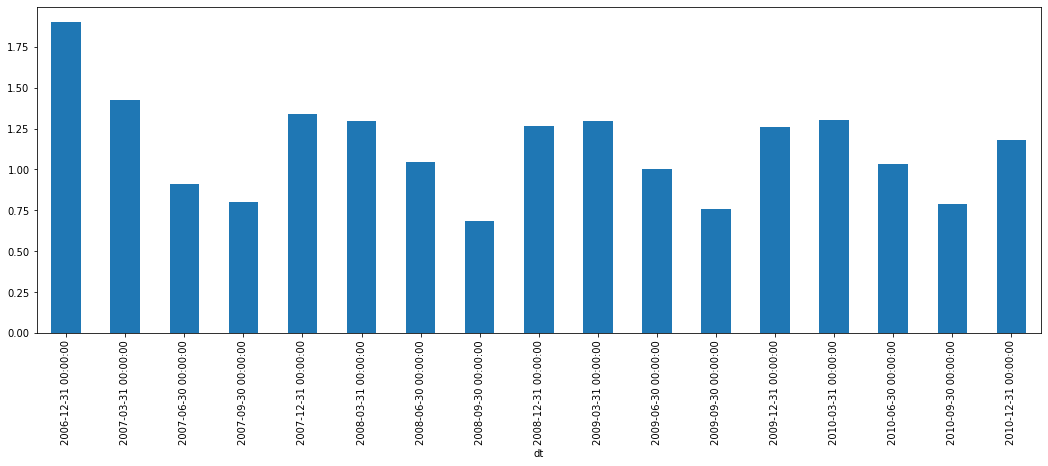

In [12]:
df['Global_active_power'].resample("Q").mean().plot(kind="bar", figsize=(18,6));

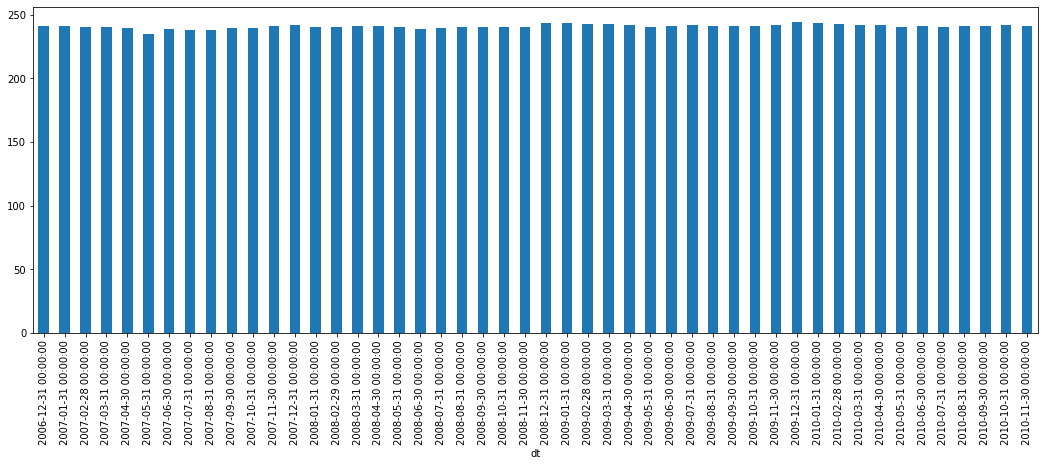

In [13]:
df['Voltage'].resample("M").mean().plot(kind="bar", figsize=(18,6));

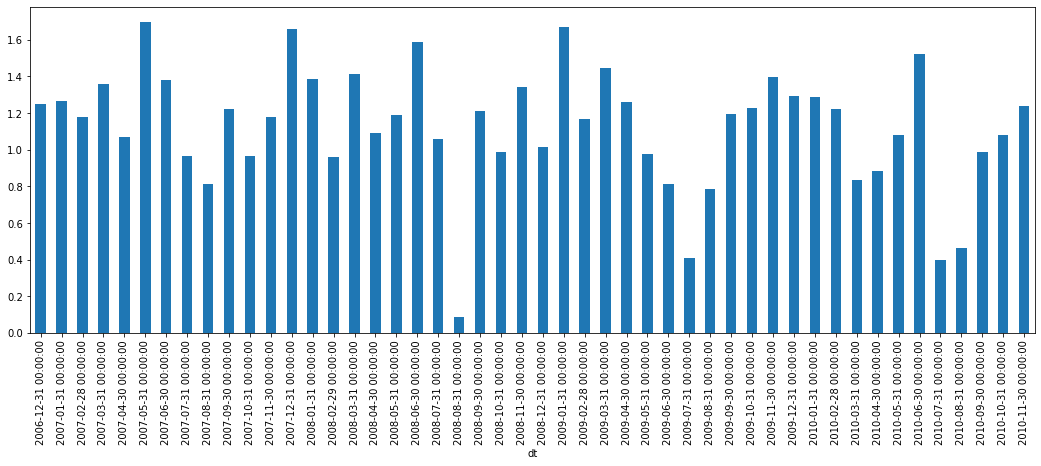

In [14]:
df['Sub_metering_1'].resample("M").mean().plot(kind="bar", figsize=(18,6));

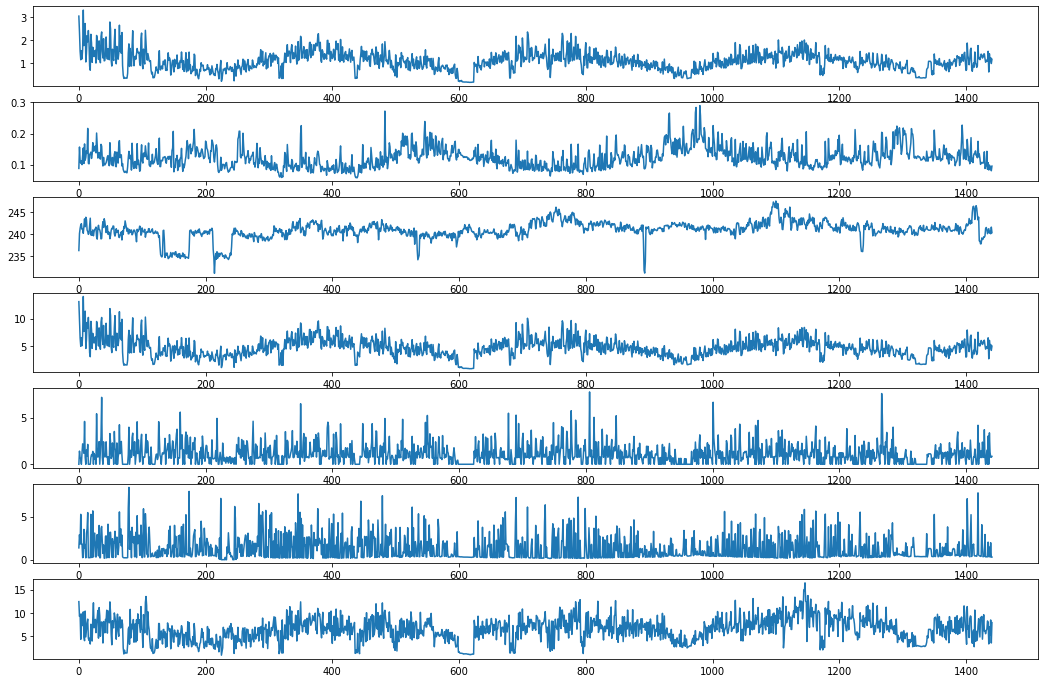

In [15]:
plt.figure(figsize=(18,12))
rs = df.resample("D").mean().values
COLS = df.columns

for i,c in enumerate(COLS):
    plt.subplot(len(COLS), 1, i+1)
    plt.plot(rs[:,i])
plt.show()

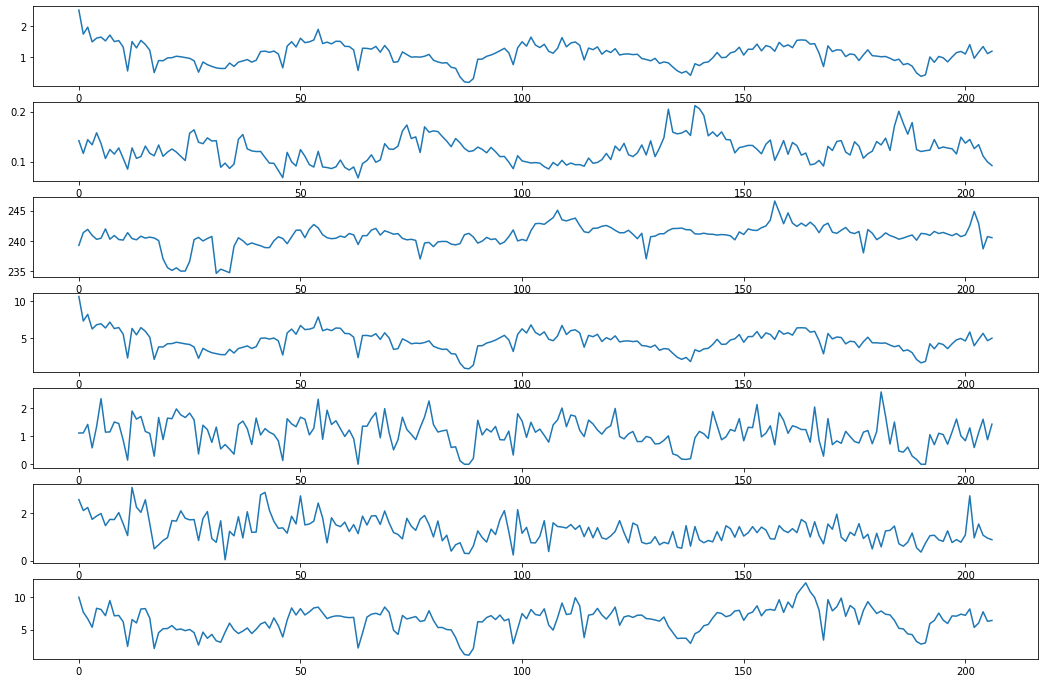

In [16]:
plt.figure(figsize=(18,12))
rs = df.resample("W").mean().values
COLS = df.columns

for i,c in enumerate(COLS):
    plt.subplot(len(COLS), 1, i+1)
    plt.plot(rs[:,i])
plt.show()

# modelo

In [78]:
from sklearn.preprocessing   import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.autograd import Variable 
from torch.utils.data import Dataset, DataLoader

import torchinfo

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

In [18]:
# resampleando para diminuir a o custo computacional
print(df.shape)
df_resamp = df.resample("h").mean()
print(df_resamp.shape)

values = df_resamp.values 

(2075259, 7)
(34589, 7)


In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

adaptando o dataset para ser input de um lstm

In [20]:
def f(data, nin=1, nout=1, dropnan=True):
    cols, cname = list(), list()
    df_ = pd.DataFrame(data)
    
    # input : t-n, t-(n-1), ... , t-1
    for i in range(nin, 0, -1):
        cols.append( df_.shift(i).copy() )
        cname += [rf"v{j+1}(t-{i})" for j in range(df_.shape[1])]
    
    # forecast : t, t+1, ... , t+(n-1), t+n
    for i in range(nout):
        cols.append( df_.shift(-i).copy() )
        if i == 0:
            cname += [rf"v{j+1}(t)" for j in range(df_.shape[1])]
        else:
            cname += [rf"v{j+1}(t+{i})" for j in range(df_.shape[1])]
    
    agg = pd.concat(cols, axis=1).dropna()
    agg.columns = cname
    
    return agg

In [21]:
df_f = f(scaled, 1, 1)
df_f

,v1(t-1),v2(t-1),v3(t-1),v4(t-1),v5(t-1),v6(t-1),v7(t-1),v1(t),v2(t),v3(t),v4(t),v5(t),v6(t),v7(t)
1,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676
2,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169
3,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809
4,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917
5,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.322555,0.072536,0.495847,0.323529,0.0,0.002872,0.205723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34584,0.146652,0.278476,0.560980,0.147298,0.0,0.020459,0.000000,0.248876,0.079294,0.431003,0.240794,0.0,0.000000,0.597061
34585,0.248876,0.079294,0.431003,0.240794,0.0,0.000000,0.597061,0.225194,0.069350,0.448732,0.219393,0.0,0.000000,0.000000
34586,0.225194,0.069350,0.448732,0.219393,0.0,0.000000,0.000000,0.238534,0.077529,0.418395,0.235055,0.0,0.001436,0.000000
34587,0.238534,0.077529,0.418395,0.235055,0.0,0.001436,0.000000,0.161531,0.078993,0.520246,0.158178,0.0,0.022972,0.000000


In [22]:
features = "v1(t-1) 	v2(t-1) 	v3(t-1) 	v4(t-1) 	v5(t-1) 	v6(t-1) 	v7(t-1) 	v1(t)".replace(" ", "").split("\t")
values = df_f[features].values

In [23]:
train = values[:365*24, :]
test = values[365*24:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [27]:
print(" features treino: ", train_X.shape, 
      "\n target treino:   ", train_y.shape, 
      "\n features teste:  ", test_X.shape, 
      "\n target teste:    ", test_y.shape) 

 features treino:  (8760, 7) 
 target treino:    (8760,) 
 features teste:   (25828, 7) 
 target teste:     (25828,)


In [28]:
# transformando em 3d : (observacao, timestamp, feature)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [29]:
print(" features treino: ", train_X.shape, 
      "\n target treino:   ", train_y.shape, 
      "\n features teste:  ", test_X.shape, 
      "\n target teste:    ", test_y.shape) 

 features treino:  (8760, 1, 7) 
 target treino:    (8760,) 
 features teste:   (25828, 1, 7) 
 target teste:     (25828,)


In [30]:
X_train_tensors = Variable(torch.Tensor(train_X))
X_test_tensors = Variable(torch.Tensor(test_X))

y_train_tensors = Variable(torch.Tensor(train_y))
y_test_tensors = Variable(torch.Tensor(test_y)) 

In [31]:
print(" features treino: ", X_train_tensors.shape, 
      "\n target treino:   ", y_train_tensors.shape, 
      "\n features teste:  ", X_test_tensors.shape, 
      "\n target teste:    ", y_test_tensors.shape) 

 features treino:  torch.Size([8760, 1, 7]) 
 target treino:    torch.Size([8760]) 
 features teste:   torch.Size([25828, 1, 7]) 
 target teste:     torch.Size([25828])


<br/>

código em keras:

```python
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(train_X, train_y, 
                    epochs=20, batch_size=70, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

# 100   neuronios
# 20%   droput
# 1     output
# (1,7) input
# MAE
# ADAM
# 20 epochs
# 70 batch size
```

tradução:

de:

```python
ConvNN_model = models.Sequential()
ConvNN_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
ConvNN_model.add(layers.MaxPooling2D((2, 2)))
ConvNN_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
ConvNN_model.add(TimeDistributed(LSTM(128, activation='relu')))
ConvNN_model.add(Dropout(0.2))
ConvNN_model.add(LSTM(128, activation='relu'))
ConvNN_model.add(layers.Dense(64, activation='relu'))
ConvNN_model.add(layers.Dropout(0.25))
ConvNN_model.add(layers.Dense(15, activation='softmax'))
```

para:

```python
class ConvNN_model(nn.Module):
    def __init__(self):
        super(ConvNN_model, self).__init__()
        self.layers = nn.Sequential(
                         nn.Conv2d(1, 32, kernel_size=3),
                         nn.ReLU(),
                         nn.MaxPool2d((2, 2)),
                         nn.Conv2d(32, 64, kernel_size=3),
                         nn.ReLU(),
                         TimeDistributed(nn.LSTM(128, 128)),
                         nn.Dropout(0.2),
                         nn.LSTM(128, 128),
                         nn.ReLU(),
                         nn.Linear(128, 64),
                         nn.ReLU(),
                         nn.Dropout(0.25),
                         nn.Linear(64, 15),
                         nn.Softmax()
                         )
    def forward(self, x):
        return self.layers(x)
```

ref: [https://stackoverflow.com/a/66955673](https://stackoverflow.com/a/66955673)

In [70]:
class TimeseriesDataset(Dataset):   
    '''
    Custom Dataset subclass. 
    Serves as input to DataLoader to transform X 
      into sequence data using rolling window. 
    DataLoader using this dataset will output batches 
      of `(batch_size, seq_len, n_features)` shape.
    Suitable as an input to RNNs. 
    '''
    def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 1):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])


In [99]:
class PowerConsumptionDataModule(pl.LightningDataModule):
    '''
    PyTorch Lighting DataModule subclass: https://pytorch-lightning.readthedocs.io/en/latest/datamodules.html
    Serves the purpose of aggregating all data loading and processing work in one place.
    '''
    
    def __init__(self, seq_len = 1, batch_size = 128, num_workers=8):
        super().__init__()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.X_test = None
        self.X_test = None
        self.columns = None
        self.preprocessing = None

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        '''
        Data is resampled to hourly intervals.
        Both 'np.nan' and '?' are converted to 'np.nan'
        'Date' and 'Time' columns are merged into 'dt' index
        '''

        if stage == 'fit' and self.X_train is not None:
            return 
        if stage == 'test' and self.X_test is not None:
            return
        if stage is None and self.X_train is not None and self.X_test is not None:  
            return
        
        df = pd.read_csv("~/Documents/data/household-power-consumption/household_power_consumption.txt",
                 sep=";", 
                 parse_dates={'dt':['Date', 'Time']},
                 infer_datetime_format=True,
                 low_memory=True,
                 na_values=['nan', '?']
                ).set_index("dt")

        df_resample = df.resample('h').mean()

        X = df_resample.dropna().copy()
        y = X['Global_active_power'].shift(-1).ffill()
        self.columns = X.columns


        X_cv, X_test, y_cv, y_test = train_test_split(
            X, y, test_size=0.2, shuffle=False
        )
    
        X_train, X_val, y_train, y_val = train_test_split(
            X_cv, y_cv, test_size=0.25, shuffle=False
        )

        preprocessing = StandardScaler()
        preprocessing.fit(X_train)

        if stage == 'fit' or stage is None:
            self.X_train = preprocessing.transform(X_train)
            self.y_train = y_train.values.reshape((-1, 1))
            self.X_val = preprocessing.transform(X_val)
            self.y_val = y_val.values.reshape((-1, 1))

        if stage == 'test' or stage is None:
            self.X_test = preprocessing.transform(X_test)
            self.y_test = y_test.values.reshape((-1, 1))
        

    def train_dataloader(self):
        train_dataset = TimeseriesDataset(self.X_train, 
                                          self.y_train, 
                                          seq_len=self.seq_len)
        train_loader = DataLoader(train_dataset, 
                                  batch_size = self.batch_size, 
                                  shuffle = False, 
                                  num_workers = self.num_workers)
        
        return train_loader

    def val_dataloader(self):
        val_dataset = TimeseriesDataset(self.X_val, 
                                        self.y_val, 
                                        seq_len=self.seq_len)
        val_loader = DataLoader(val_dataset, 
                                batch_size = self.batch_size, 
                                shuffle = False, 
                                num_workers = self.num_workers)

        return val_loader

    def test_dataloader(self):
        test_dataset = TimeseriesDataset(self.X_test, 
                                         self.y_test, 
                                         seq_len=self.seq_len)
        test_loader = DataLoader(test_dataset, 
                                 batch_size = self.batch_size, 
                                 shuffle = False, 
                                 num_workers = self.num_workers)

        return test_loader

In [146]:
class SimpleModel(pl.LightningModule):
    def __init__(self,  
                 n_features, 
                 hidden_size, 
                 seq_len, 
                 batch_size,
                 num_layers, 
                 dropout, 
                 learning_rate,
                 criterion):
        super(SimpleModel, self).__init__()
        
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.criterion = criterion
        self.learning_rate = learning_rate
        
        self.lstm = torch.nn.LSTM(
            input_size = n_features, 
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout = dropout,
            batch_first=True
        )
        self.linear = torch.nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out[:,-1])
        return y_pred
            
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        tensorboard_logs = {'train_loss': loss} # self.log('train_loss', loss)
        return {'loss': loss, 'preds': y_hat.detach(), 'log': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        tensorboard_logs = {'val_loss': loss} # self.log('val_loss', loss)
        return {'loss': loss, 'preds': y_hat.detach(), 'log': tensorboard_logs}
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        # self.log('test_loss', loss)
        return {'loss': loss, 'preds': y_hat.detach()}

In [147]:
p = dict(
    seq_len = 24,
    batch_size = 70, 
    criterion = torch.nn.MSELoss(),
    max_epochs = 10,
    n_features = 7,
    hidden_size = 100,
    num_layers = 1,
    dropout = 0.2,
    learning_rate = 0.001,
)

In [151]:
seed_everything(22)

VERSAO = '1'

csv_logger = CSVLogger(rf'./LOGS_{VERSAO}', name='lstm', version=VERSAO),

checkpoint = ModelCheckpoint(dirpath=rf'./LOGS_{VERSAO}', filename=rf"lstm_{VERSAO}")

trainer = Trainer(
    max_epochs=p['max_epochs'],
    progress_bar_refresh_rate=2,
    logger=csv_logger,
    callbacks=[checkpoint]
)

model = SimpleModel(
    n_features = p['n_features'],
    hidden_size = p['hidden_size'],
    seq_len = p['seq_len'],
    batch_size = p['batch_size'],
    criterion = p['criterion'],
    num_layers = p['num_layers'],
    dropout = p['dropout'],
    learning_rate = p['learning_rate']
)

Global seed set to 22
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [152]:
dm = PowerConsumptionDataModule(
    seq_len = p['seq_len'],
    batch_size = p['batch_size']
)

In [153]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
SimpleModel                              --
├─MSELoss: 1-1                           --
├─LSTM: 1-2                              43,600
├─Linear: 1-3                            101
Total params: 43,701
Trainable params: 43,701
Non-trainable params: 0

In [154]:
%%time
trainer.fit(model, dm)

/home/dusodeth/.local/lib/python3.8/site-packages/pytorch_lightning/loggers/csv_logs.py:57: UserWarning: Experiment logs directory ./LOGS_1/lstm/1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 43.6 K
2 | linear    | Linear  | 101   
--------------------------------------
43.7 K    Trainable params
0         Non-trainable params
43.7 K    Total params
0.175     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 22


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 7min 43s, sys: 6.09 s, total: 7min 49s
Wall time: 1min 7s


In [155]:
%%time
trainer.test(model, datamodule=dm)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
CPU times: user 9.23 s, sys: 288 ms, total: 9.51 s
Wall time: 5.8 s


[{}]

# analise

In [156]:
metrics = pd.read_csv('LOGS_1/lstm/1/metrics.csv')

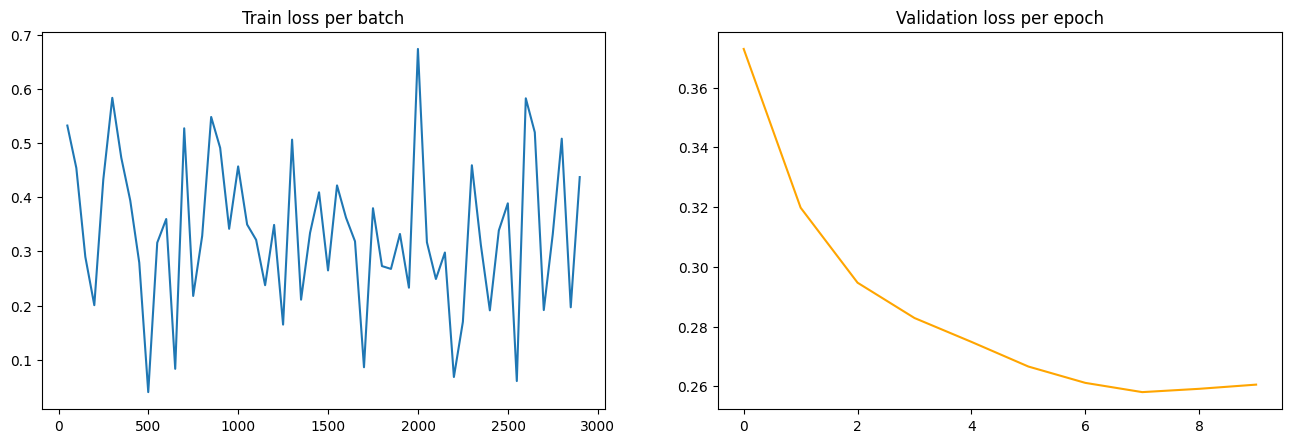

MSE:
Train loss: 0.437
Val loss:   0.261
Test loss:  0.246


In [157]:
train_loss = metrics[['train_loss', 'step', 'epoch']][~np.isnan(metrics['train_loss'])]
val_loss = metrics[['val_loss', 'epoch']][~np.isnan(metrics['val_loss'])]
test_loss = metrics['test_loss'].iloc[-1]

fig, axes = plt.subplots(1, 2, figsize=(16, 5), dpi=100)
axes[0].set_title('Train loss per batch')
axes[0].plot(train_loss['step'], train_loss['train_loss'])
axes[1].set_title('Validation loss per epoch')
axes[1].plot(val_loss['epoch'], val_loss['val_loss'], color='orange')
plt.show(block = True)

print('MSE:')
print(f"Train loss: {train_loss['train_loss'].iloc[-1]:.3f}")
print(f"Val loss:   {val_loss['val_loss'].iloc[-1]:.3f}")
print(f'Test loss:  {test_loss:.3f}')

- - -

In [183]:
# X_train_tensors = Variable(torch.Tensor(train_X))
# X_test_tensors = Variable(torch.Tensor(test_X))

# y_train_tensors = Variable(torch.Tensor(train_y))
# y_test_tensors = Variable(torch.Tensor(test_y)) 

X_test_tensors.shape

torch.Size([25828, 1, 7])

In [200]:
y_hat = [float(i[0][0]) for i in trainer.predict(model, DataLoader(X_test_tensors))]

Predicting: 293it [00:00, ?it/s]

In [209]:
N = 250
DT = [i for i in range(N)]

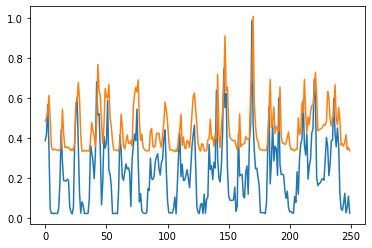

In [214]:
plt.plot(DT, y_test_tensors[:N], label="VDD")
plt.plot(DT, y_hat[:N], label="PRED")

comentário: ao longo do estudo foram usadas padronizadores diferentes, mas dá pra ver que o perfil da curva foi aprendido.

.